# Image classification with multilayer perceptron (MLP)

In this lab we design and train our first MLP network, and we use it for image classification.

In [15]:
import os
import random
import numpy as np
import torch 
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
from skimage import io, transform
from torch.utils.data import DataLoader, random_split, Subset
import copy

## Dataset

In this lab, we use the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset, which is a large image dataset of hand-written digits.

<center><a href="https://en.wikipedia.org/wiki/MNIST_database">
    <img src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png"></a></center>

Just like some other widely-used datasets, MNIST can be downloaded directly from Pytorch, and includes specific commands to create a `Dataset` object, thus you don't have to do it manually as we did in lab 1.

In [16]:
# Define the data repository
data_dir = 'data/'

# Choose one (or several) transform(s) to preprocess the data
data_transforms = torchvision.transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# Create a Dataset (you can download the data by setting 'download=True')
train_data = torchvision.datasets.MNIST(data_dir, train=True, download=True, transform=data_transforms)
test_data = torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=data_transforms)
num_classes = len(train_data.classes)
print('Number of classes in the dataset:', num_classes)

# We are not going to work with the full dataset (which is very big), so we only keep small train and test subsets.
train_data = Subset(train_data, torch.arange(400))
test_data = Subset(test_data, torch.arange(50))
print('Number of images in the train dataset', len(train_data))
print('Number of images in the train dataset', len(test_data))

Number of classes in the dataset: 10
Number of images in the train dataset 400
Number of images in the train dataset 50


torch.Size([1, 28, 28])
Image label= 5


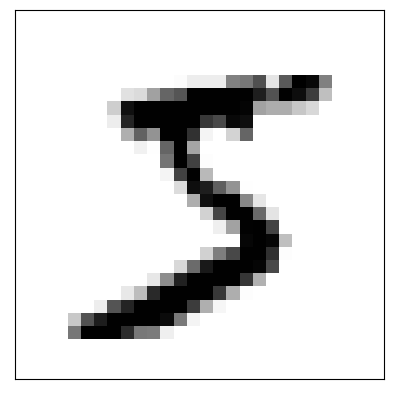

In [17]:
# Fetch one data pair (one image and the corresponding label)
image, label = train_data[0]
print(image.shape)
print('Image label=', label)

# You should note that the size of the image is [1, 28, 28], which corresponds to [num_channels, height, width]
# Indeed, MNIST images are in black and white so there is only 1 color channel.
# To plot this image, we need to remove this channel dimension by using squeeze()

plt.figure()
plt.imshow(image.squeeze(), cmap='gray_r')
plt.xticks([]), plt.yticks([])
plt.show()

In [18]:
# TO DO:
# - create two dataloaders (for the training and testing subsets) with a batch size of 8
# - print the number of batches in the training subset
batch_size=8
train_dataloader = DataLoader(dataset = train_data, batch_size=8, shuffle=True)
len(train_dataloader)

50

In [19]:
# Get a batch of images and corresponding labels from the train dataloader
batch_example = next(iter(train_dataloader))
image_batch_example = batch_example[0]
labels_batch_example = batch_example[1]

# Print the size of the batch of images and labels
print(image_batch_example.shape)
print(labels_batch_example.shape)

torch.Size([8, 1, 28, 28])
torch.Size([8])


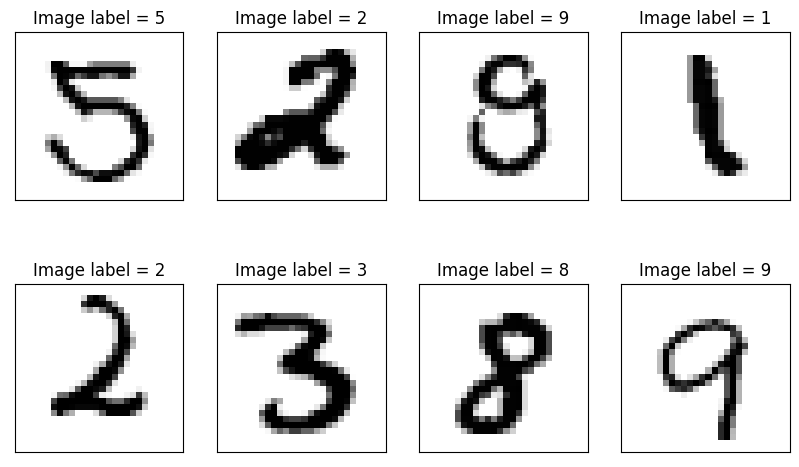

In [20]:
# Plot the images in the batch (along with the corresponding label)
plt.figure(figsize = (10,6))
for ib in range(batch_size):
    plt.subplot(batch_size // 4, 4, ib+1)
    plt.imshow(image_batch_example[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Image label = ' + str(labels_batch_example[ib].item()))
plt.show()

## MLP network

A typical MLP network is composed of several layers:

- an *input* layer, which takes a batch of vectors and computes the first hidden representation.
- one or several *hidden* layers.
- an *output* layer, which computes the output of the network.

Each layer consists of a linear part and a non-linear *activation* functions (except for the output layer, which usually don't use an activation function). There are many non-linear activation functions in Pytorch, check the [documentation](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) for a complete overview. A network is said to be *deep* if it has at least 3 layers (input, at least one hidden, and output).

<center><a href="https://www.researchgate.net/publication/309592737_Classification_of_VoIP_and_non-VoIP_traffic_using_machine_learning_approaches">
    <img src="https://www.researchgate.net/profile/Mouhammd-Alkasassbeh/publication/309592737/figure/fig2/AS:423712664100865@1478032379613/MultiLayer-Perceptron-MLP-sturcture-334-MultiLayer-Perceptron-Classifier-MultiLayer.png"></a></center>

**Note**: Since an MLP manipulates vectors (= 1D-tensors) as inputs, in image processing we first have to transform our images into vectors. For instance, if each image is a tensor of size `[1, 28, 28]`, then we have to reshape it into a tensor of size `[1x28x28] = [784]`.


### Example

First, we will write a succession of operations which correspond to applying the MLP classifier on the example batch `image_batch_example`.

In [21]:
# TO DO: reshape the image_batch_example into a batch of vectors (vectorized images):
# 'image_batch_example' has size [batch_size, 1, 28, 28]
# 'vectorized_batch' should have size [batch_size, 1*28*28]
vectorized_batch = image_batch_example.view(-1, 784)

In [22]:
# Now we create the input layer (linear and activation) and we pass the vectorized batch to it
input_size = vectorized_batch.shape[-1]
hidden_size = 10
input_layer = nn.Sequential(nn.Linear(input_size, hidden_size), nn.Sigmoid())
y = input_layer(vectorized_batch)
print(y.shape)

torch.Size([8, 10])


In [23]:
# TO DO: create the two other layers (hidden_layer and output_layer):
# - the hidden layer goes from 'hidden_size' to 'hidden_size', and uses a Sigmoid activation function
# - the output layer goes from 'hidden_size' to 'output_size', which is the number of classes in the dataset (it uses no activation function)
# - Compute z = hidden_layer(y) and out=output_layer(z). Print the size of 'out'.
hidden_layers = nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.Sigmoid())
output_layer = nn.Sequential(nn.Linear(hidden_size, hidden_size))
z = hidden_layers(y)
out = output_layer(z)
print(out.shape)

torch.Size([8, 10])


From what we have done above, two important remarks can be made:

- The output `out` has size `[batch_size, num_classes]` while the true labels `labels_batch_example` has size `[batch_size]`. This is because `out` contains a predicted probability for each class, while `labels_batch_example` simply contains the true labels.
- In classification tasks, we want to output probabilities per class. However, nothing ensures that `out` corresponds to probabilities, since it is not normalized and we didn't use any output activation function (values can be negative and not sum up to 1).

However, when training a classification network, we generally use the [Cross Entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) loss function, which alleviates these two issues. This loss is optimized for handling true labels instead of true probabilities per class, so you don't have to worry about it. Besides, it will automatically apply a [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) non-linearity to the predicted outputs, in order to normalize them as probabilities per class.

**Note**: Instead of Cross Entropy, you can use the [Negative log-likelihood](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss) similarly. It will also solve the first problem, but then you need to manually add a [log Softmax](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html#torch.nn.LogSoftmax) as output activation to normalize the outputs.

In [24]:
# Choose Cross Entropy as loss function
loss_fn = nn.CrossEntropyLoss()

# Compute the error between the predicted labels 'out' and true labels 'labels_batch_example'
loss_batch = loss_fn(out, labels_batch_example)
print(loss_batch.item())

2.476112127304077


### General module

Now, let's create a general MLP classification network. It's a python class that inherits from the general `nn.Module` object, and it should contain at least 2 methods:

- `__init__`, which initializes the network when instanciated (creates all the layers and stores some useful parameters if needed).
- `forward`, which applies the forward pass (i.e., compute the output 'out' from the input and using the layers).

You can add other methods if needed but these two are sufficient for now.

**Note**: Remember that Python classes usually define and use some variables/data/tensors/dictionary etc. internally (this includes network layers) called *attributes*: they should be defined in the `__init__` method with a specific structure (the name should start by `self.`, as we did in lab 1). This allows you to access these attributes in other methods, or after defining your network.

In [68]:
class MLPClassif(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, act_fn):
        super(MLPClassif, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_size)
        self.hidden2 = nn.Linear(hidden_size, hidden_size)
        self.out_layer = nn.Linear(hidden_size, output_size)
        self.act_fn = act_fn
    
    def forward(self, x):
        
        # TO DO: write the 'forward' method, which computes the output 'out' from the input x
        # It should apply sequentially the input, hidden, and output layer, as we did in the example before.
        #x = x.view(-1, 784)
        x = self.act_fn(self.hidden1(x))
        x = self.act_fn(self.hidden2(x))
        out = self.out_layer(x)
        return out

In [69]:
# To DO: Create an MLP classifier with a hidden size of 10 and a Sigmoid activation function
model = MLPClassif(784, 10, 10, nn.Sigmoid())

In [70]:
# initialization (ensure reproducibility: everybody should have the same results)
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.fill_(0.01)

torch.manual_seed(0)
model.apply(init_weights)

MLPClassif(
  (hidden1): Linear(in_features=784, out_features=10, bias=True)
  (hidden2): Linear(in_features=10, out_features=10, bias=True)
  (out_layer): Linear(in_features=10, out_features=10, bias=True)
  (act_fn): Sigmoid()
)

In [71]:
# You can save / load the model's parameters as follow:
torch.save(model.state_dict(), 'model_mlp_classif.pt')
model.load_state_dict(torch.load('model_mlp_classif.pt'))

<All keys matched successfully>

In [72]:
# A useful command to get the total number of parameters in the model
print('Total number of parameters:', sum(p.numel() for p in model.parameters()))

Total number of parameters: 8070


<span style="color:red">**Q1**</span> How many parameters are in the network?

## Training

We now write the function for training the network. It's very similar to what we did in lab 2, except now we process batches of data instead of the whole dataset at each epoch.

In [75]:
def training_mlp_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):

    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)
    
    # Set the model in 'training' mode (ensures all parameters' gradients are computed - it's like setting 'requires_grad=True' for all parameters)
    model_tr.train()
    
    # Define the optimizer
    optimizer = torch.optim.SGD(model_tr.parameters(), lr=learning_rate)
    
    # Initialize a list to record the training loss over epochs
    loss_all_epochs = []
    
    # Training loop
    for epoch in range(num_epochs):
        # Initialize the training loss for the current epoch
        loss_current_epoch = 0
        
        # Iterate over batches using the dataloader
        for batch_index, (images, labels) in enumerate(train_dataloader):
            
            # TO DO: write the training procedure for each batch. This should consist of:
            # - vectorizing the images (size should be (batch_size, input_size))
            # - apply the forward pass (calculate the predicted labels from the vectorized images)
            # - use the 'backward' method to compute the gradients
            # - apply the gradient descent algorithm
            # Also think of updating the loss at the current epoch
            y_pred = model_tr(images.view(-1, 784))
            l = loss_fn(y_pred, labels)
            optimizer.zero_grad()
            l.backward()
            loss_current_epoch += l.item()
            optimizer.step() #update parameters

        # At the end of each epoch, record and display the loss over all batches
        loss_all_epochs.append(loss_current_epoch)
        if verbose:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss_current_epoch))
        
    return model_tr, loss_all_epochs

In [76]:
# TO DO: Define the training parameters and train the model
# - 30 epochs
# - learning rate = 0.01
# - loss function: Cross Entropy
# After training, save the model parameters and display the loss over epochs
num_epochs = 30
learning_rate = 0.01
loss_fn = nn.CrossEntropyLoss()
model_trained, history =training_mlp_classifier(model, train_dataloader, num_epochs,loss_fn , learning_rate, verbose=True)

Epoch [1/30], Loss: 117.7536
Epoch [2/30], Loss: 115.5926
Epoch [3/30], Loss: 114.2603
Epoch [4/30], Loss: 113.2905
Epoch [5/30], Loss: 112.4923
Epoch [6/30], Loss: 111.7940
Epoch [7/30], Loss: 111.1618
Epoch [8/30], Loss: 110.5733
Epoch [9/30], Loss: 110.0480
Epoch [10/30], Loss: 109.5561
Epoch [11/30], Loss: 109.0802
Epoch [12/30], Loss: 108.6102
Epoch [13/30], Loss: 108.1820
Epoch [14/30], Loss: 107.7626
Epoch [15/30], Loss: 107.3229
Epoch [16/30], Loss: 106.9040
Epoch [17/30], Loss: 106.4851
Epoch [18/30], Loss: 106.0759
Epoch [19/30], Loss: 105.6368
Epoch [20/30], Loss: 105.2186
Epoch [21/30], Loss: 104.7988
Epoch [22/30], Loss: 104.3522
Epoch [23/30], Loss: 103.9199
Epoch [24/30], Loss: 103.4725
Epoch [25/30], Loss: 103.0238
Epoch [26/30], Loss: 102.5687
Epoch [27/30], Loss: 102.0828
Epoch [28/30], Loss: 101.6314
Epoch [29/30], Loss: 101.1396
Epoch [30/30], Loss: 100.6679


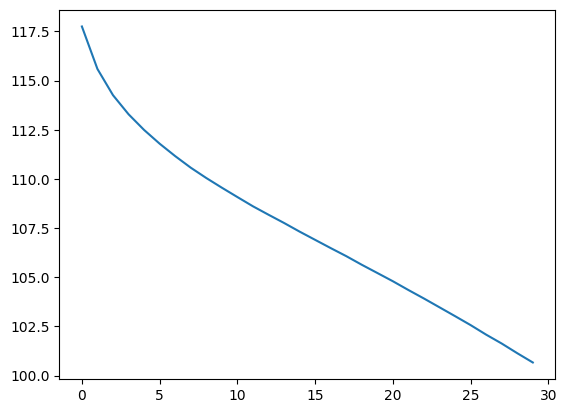

In [77]:
plt.plot(range(30), history)

<span style="color:red">**Q2**</span> Put the plot above (loss over epochs) in your report. Do you remark something particular?


## Evaluation

Now the model is trained, we can evaluate it on the test dataset. We do that by predicting the labels using our model, and comparing it with the true labels. This allows us to compute the classification accuracy, which is provided in the function below.

In [78]:
# Evaluation function: similar to the training loop, except we don't need to compute any gradient / backprop

def eval_mlp_classifier(model, eval_dataloader):
    
    # Set the model in 'evaluation' mode (this disables some layers (batch norm, dropout...) which are not needed when testing)
    model.eval() 

    # In evaluation phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct_labels = 0
        total_labels = 0
        
        # Iterate over the dataset using the dataloader
        for images, labels in eval_dataloader:

            # Get the predicted labels
            images = images.reshape(images.shape[0], -1)
            y_predicted = model(images)
            
            # To get the predicted labels, we need to get the max over all possible classes
            _, label_predicted = torch.max(y_predicted.data, 1)
            
            # Compute accuracy: count the total number of samples, and the correct labels (compare the true and predicted labels)
            total_labels += labels.size(0)
            correct_labels += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct_labels / total_labels
    
    return accuracy

In [79]:
# TO DO: Evaluate the model on the test set:
# - Instanciate an MLP newtork and load the trained parameters
# - Apply the evaluation function using the test dataloader
# - Print the test accuracy
eval_dataloader = DataLoader(dataset=test_data, batch_size=8, shuffle=True)
eval_mlp_classifier(model_trained, eval_dataloader)

68.0

<span style="color:red">**Q3**</span> What is the accuracy on the test set? Given your answer at Q2, how could you improve it?

## Influence of the activation function

We used the MLP classifier with a Sigmoid activation function, but another common choice is the [Rectified Linear Unit](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU). Here we investigate how it performs compared to the Sigmoid-based network.

In [81]:
# TO DO: Define an MLP classifier using a ReLU activation. 
model_relu = MLPClassif(784, 10, 10, nn.ReLU())
torch.manual_seed(0)
model_relu.apply(init_weights)

MLPClassif(
  (hidden1): Linear(in_features=784, out_features=10, bias=True)
  (hidden2): Linear(in_features=10, out_features=10, bias=True)
  (out_layer): Linear(in_features=10, out_features=10, bias=True)
  (act_fn): ReLU()
)

In [ ]:
# Initialize the weights (for reproducibility)
torch.manual_seed(0)
model_relu.apply(init_weights)

In [82]:
# TO DO: Train the network and evaluate it.
loss_fn = nn.CrossEntropyLoss()
model_rel, history_relu =training_mlp_classifier(model_relu, train_dataloader, num_epochs, loss_fn , learning_rate, verbose=True)

Epoch [1/30], Loss: 111.0200
Epoch [2/30], Loss: 87.0971
Epoch [3/30], Loss: 63.1073
Epoch [4/30], Loss: 43.8110
Epoch [5/30], Loss: 32.5900
Epoch [6/30], Loss: 26.0662
Epoch [7/30], Loss: 21.1643
Epoch [8/30], Loss: 18.1869
Epoch [9/30], Loss: 15.9250
Epoch [10/30], Loss: 13.3611
Epoch [11/30], Loss: 11.6802
Epoch [12/30], Loss: 10.1836
Epoch [13/30], Loss: 9.0038
Epoch [14/30], Loss: 7.8001
Epoch [15/30], Loss: 6.6990
Epoch [16/30], Loss: 6.1856
Epoch [17/30], Loss: 5.2585
Epoch [18/30], Loss: 4.7580
Epoch [19/30], Loss: 4.1173
Epoch [20/30], Loss: 3.8827
Epoch [21/30], Loss: 3.4320
Epoch [22/30], Loss: 3.2127
Epoch [23/30], Loss: 2.8881
Epoch [24/30], Loss: 2.6619
Epoch [25/30], Loss: 2.4818
Epoch [26/30], Loss: 2.2787
Epoch [27/30], Loss: 2.0922
Epoch [28/30], Loss: 1.9625
Epoch [29/30], Loss: 1.8065
Epoch [30/30], Loss: 1.6929


<span style="color:red">**Q4**</span> What is the accuracy on the test set with this network? Which one (Sigmoid or ReLU) would you recommend to use?

In [83]:
eval_mlp_classifier(model_rel, eval_dataloader)

90.0

## Increasing the model capacity (bonus)

In order to improve performance, a straightforward approach is to increase the model capacity, i.e., increase the number of parameters. There are basically two ways to do so: either increase the number of neurons in each layer (*width*) of increase the total number of layers (*depth*). Let's focus here on width.

In [90]:
# TO DO: define, train and evalute an MLP classifier model with a variable hidden_size:
# - hidden_size should range in [3, 5, 10, 50, 100]
# - the networks should use ReLU activation, and be trained for 30 epochs
# - for each hidden size, print the number of parameters and the test accuracy
# Remember to initialize the weights of the network after instanciating it for reproducibility.
total_accuracy = []
for size in [3, 5, 10, 50, 100]:
    model = MLPClassif(784, size, 10, nn.ReLU())
    print(f'Total number of parameters for size {size}:, {sum(p.numel() for p in model.parameters())}')
    torch.manual_seed(0)
    model.apply(init_weights)
    loss_fn = nn.CrossEntropyLoss()
    model_trained, _ = training_mlp_classifier(model, train_dataloader,
                                                    num_epochs, loss_fn , learning_rate, verbose=True)
    total_accuracy.append(eval_mlp_classifier(model_trained, eval_dataloader))

Total number of parameters for size 3:, 2407
Epoch [1/30], Loss: 112.6230
Epoch [2/30], Loss: 106.4710
Epoch [3/30], Loss: 103.1295
Epoch [4/30], Loss: 99.0038
Epoch [5/30], Loss: 94.5046
Epoch [6/30], Loss: 91.1967
Epoch [7/30], Loss: 87.5121
Epoch [8/30], Loss: 84.2957
Epoch [9/30], Loss: 81.4426
Epoch [10/30], Loss: 79.2097
Epoch [11/30], Loss: 77.3063
Epoch [12/30], Loss: 75.5163
Epoch [13/30], Loss: 73.7027
Epoch [14/30], Loss: 72.2987
Epoch [15/30], Loss: 70.8609
Epoch [16/30], Loss: 69.5475
Epoch [17/30], Loss: 68.2597
Epoch [18/30], Loss: 67.2061
Epoch [19/30], Loss: 66.0017
Epoch [20/30], Loss: 64.9458
Epoch [21/30], Loss: 63.8240
Epoch [22/30], Loss: 62.8806
Epoch [23/30], Loss: 61.9313
Epoch [24/30], Loss: 61.0449
Epoch [25/30], Loss: 60.0988
Epoch [26/30], Loss: 59.2603
Epoch [27/30], Loss: 58.5620
Epoch [28/30], Loss: 57.8345
Epoch [29/30], Loss: 57.1364
Epoch [30/30], Loss: 56.2695
Total number of parameters for size 5:, 4015
Epoch [1/30], Loss: 108.7695
Epoch [2/30], Los

<span style="color:red">**Q5**</span> Report the test accuracy as a function of `hidden_size`. Which value of `hidden_size` would you use and why?

Text(0, 0.5, 'Accuracy')

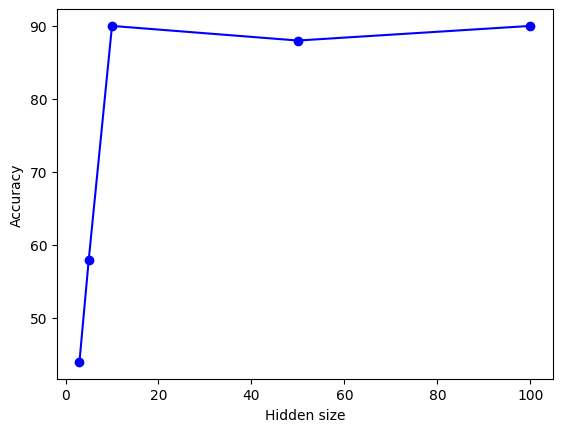

In [96]:
plt.plot([3, 5, 10, 50, 100], total_accuracy, 'b-o')
plt.xlabel('Hidden size')
plt.ylabel('Accuracy')